# Medical Image Segmentation - PDE, Deformable or Contour based methods 

#### In order to complete this laboratory task you should review the instruction file (Lab4_3 Instruction.pdf) beforehand.

## TASK3) Edge-Based Energy

#### The framework is almost the same as previous task but here, we are going to use an edge-based energy functional.The goal is to segment lung region.

In [1]:
# just for read
import cv2 # image processing and machine vision package
import numpy as np
from scipy import interpolate as ip
import matplotlib.pyplot as plt
from scipy.interpolate import spline
import scipy.ndimage as nd
from Functions3 import *

In [2]:
# Just for read.
# function for setting the points on the image and creating a mask.

refPt = [] # Selected points by user
flag = True # for right click checking

def Mask_Generator(shape,interpX,interpY): # Generate edge(mask) and filled(mask2) Masks
        mask = np.zeros(shape)
        for i in range(len(interpX)):
                mask[interpX[i],interpY[i]]=1
        a,b = shape
        mask2 = np.zeros(shape)
        for i in range(a):
                MaskRow = mask[i,:]
                Index = np.where(MaskRow==1)[0]
                if len(Index)==0:
                        continue
                SIndex = Index[0] # First index of ones from left
                EIndex = Index[-1]# First index of ones from right
                for j in range(SIndex,EIndex): # Fill between them!
                        mask2[i,j]=1
        return (mask,mask2)
# Open the image window for mouse clicks (for click_and_crop function)and as soon as flag gets false this will close the image window
def Selection(imageC):
        global refPt
        while flag:
                cv2.imshow('image', imageC)
                key = cv2.waitKey(10) & 0xFF
                if key == ord("z"): # break the loop if 'z' pressed. not necessary
                        break
def click_and_crop(event, x, y, flags, param): # event handler of clicks
        global refPt,flag,image
        if (event == cv2.EVENT_LBUTTONDOWN): # if left click:
                refPt.append((y, x))
                cv2.circle(imageC,(x,y),3,(255,0,0),-1)
        elif (event == cv2.EVENT_RBUTTONDOWN): # if right click:
                refPt.append((y, x))
                cv2.circle(imageC,(x,y),5,(0,255,255),-1)
                flag=False

In [3]:
# Just for read.
# Here we load the input image (a CT lung image) and select some arbitrary points to create a mask as initial contour.
# The output mask is which will be employed as initial contour named as "init_mask"
imgname = 'lung.jpg'
image = cv2.imread(imgname,0) # grayscale for process
imageC = cv2.imread(imgname)  # color for presentation
cv2.namedWindow("image")
cv2.setMouseCallback("image", click_and_crop)
Selection(imageC)
points = np.asarray(refPt)
LXs = points[:,0] # x of first selection
LXt = list(LXs)
LXt.append(points[0,0]) # add the first points to the end of the list for create circular structure
LXs = np.asarray(LXt)
LYs = points[:,1]
LYt = list(LYs)
LYt.append(points[0,1])
LYs = np.asarray(LYt)
tckL,uL = ip.splprep( [LXs,LYs] ,k=3 )
xnewL,ynewL = ip.splev( np.linspace( 0, 1, 1600 ), tckL,der = 0)
rounded_xnewL = np.int64(np.round_(xnewL))
rounded_ynewL = np.int64(np.round_(ynewL))
(lm,init_mask) = Mask_Generator(image.shape,rounded_xnewL,rounded_ynewL)

In [4]:
# TODOs
# TODO set a maximum number of iteration
max_its= 20
display=True
eps = np.finfo(float).eps
# #the propagation term c: it is as a constant that acts as a balloon force pushing the contour either inward or outward (default value is set to 1).
# TODO set a value for c parameter
propag = 1
color='g'
# TODO a threshold value for stopping criteria
thresh = 0.1

In [5]:
# just for read
# Gaussian filter
def fspecial_gauss(size, sigma):
    x, y = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]
    g = np.exp(-((x**2 + y**2)/(2.0*sigma**2)))
    return g/g.sum()

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  


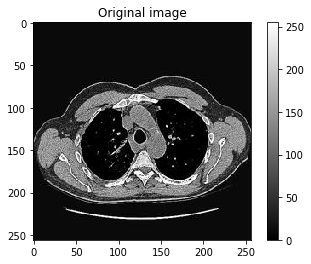

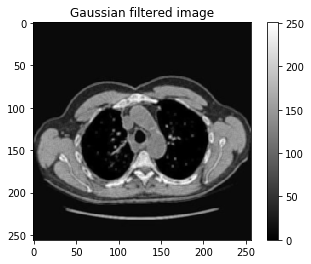

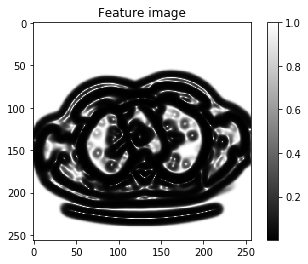

In [8]:
# TODOs:
I = nd.imread(imgname, flatten=True)
I = I.astype(np.float)
# TODO: show the image
plt.figure()
plt.imshow(I,cmap='gray')
plt.title('Original image')
plt.colorbar()
# TODO: define a gaussian smoothing filter of size 3.
Filter = fspecial_gauss(3,3)
# Filter the input image with defind smoothing filter using "nd.convolve"
SmoothImage = nd.convolve(I,Filter)
# show the smoothed image
plt.figure()
plt.imshow(SmoothImage,cmap='gray')
plt.title('Gaussian filtered image')
plt.colorbar()
# calculate the magnitude of gradient applied over the smoothed image using "nd.gaussian_gradient_magnitude"
NormGrad = nd.gaussian_gradient_magnitude(SmoothImage,3)
Num = 1;
Denum = 1+np.power(NormGrad,2)
# Compute the feature image as Num/Denum
Feature = Num/Denum
# show the feature image
plt.figure()
plt.imshow(Feature,cmap='gray')
plt.title('Feature image')
plt.colorbar()

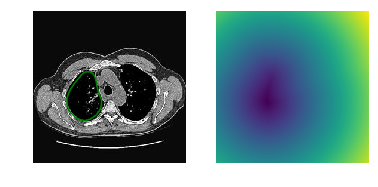

In [9]:
# Create a signed distance map (SDF) from mask
phi = mask2phi(init_mask)
# intermediate plotting
if display:
    plt.ion()
    fig, axes = plt.subplots(ncols=2)
    show_curve_and_phi(fig, I, phi, color)

iteration: 0


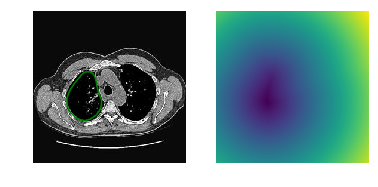

In [10]:
# just for read
# Main loop
its = 0
stop = False
prev_mask = init_mask
c = 0
while (its < max_its and not stop):
    # Get the curve's narrow band
    idx = np.flatnonzero(np.logical_and(phi <= 1.2, phi >= -1.2))

    if len(idx) > 0:
        # Intermediate output
        if display:
            if np.mod(its, 500) == 0:
                plt.ion()
                fig2, axes = plt.subplots(ncols=2)
                print('iteration: {0}'.format(its))
                show_curve_and_phi(fig2, I, phi, color)
        else:
            if np.mod(its, 10) == 0:
                print('iteration: {0}'.format(its))


        # Force from image information
        F = Feature.flat[idx]
        curvature, normGrad, FdotGrad = Evolution(phi,Feature,idx)

        # Gradient descent to minimize energy
        Var1 = np.multiply(F,curvature)
        dphidt1 = np.multiply(Var1,normGrad)
        dphidt1 = dphidt1/np.max(np.abs(dphidt1))

        dphidt2 = FdotGrad
        dphidt2 = dphidt2/np.max(np.abs(dphidt2))

        dphidt3 = np.multiply(F,normGrad)
        dphidt3 = dphidt3/np.max(np.abs(dphidt3))

        dphidt = dphidt1+dphidt2-propag*dphidt3

        # Maintain the Courant–Friedrichs–Lewy (CFL) condition 
        dt = 0.45 / (np.max(np.abs(dphidt)) + eps)

        # Evolve the curve
        phi.flat[idx] += dt * dphidt

        # Keep SDF smooth
        phi = sussman(phi, 0.5)

        new_mask = phi <= 0
        c = convergence(prev_mask, new_mask, thresh, c)

        if c <= 5:
            its = its + 1
            prev_mask = new_mask
        else:
            stop = True

    else:
        break


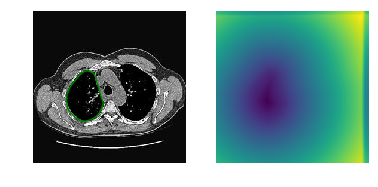

In [11]:
# Final output
if display:
    plt.ion()
    fig3, axes = plt.subplots(ncols=2)
    show_curve_and_phi(fig3, I, phi, color)

# Make mask from SDF
seg = phi <= 0  # Get mask from levelset